# Demonstration of DCBC evaluation usage 
This notebook shows an example of a Distance controlled boundary coefficient (DCBC) evaluation of a cortical parcellation using the Multi-domain task battery (MDTB) functional dataset. 

## Installation and Requirments

Ensure Python version >= 3.6 and pip installed on your system.

- Install Python at https://www.python.org/downloads/
- Install pip: https://pip.pypa.io/en/stable/installing/

## Dependencies

`pip install nibabel scipy numpy sklearn matplotlib`

## Project structure

```
project/
│   README.md
│   eval_DCBC.py
│   plotting.py
│   sample.py
│   sample.ipynb
│
└───distanceMatrix/
│       disAvrg_sp.mat
│       ...
│   
└───parcellations/
│       └───random/
│       │       Icosahedron-42.32k.L.label.gii
│       │       ...
│       AAL.32k.L.label.gii
│       ...
│   
└───data/
        s02
        s03
	...
	s31
```

## Usage
Below is a quick sample script of using the DCBC evaluation for evaluating `Power 2011` left hemisphere.

In [3]:
from eval_DCBC import DCBC
from plotting import plot_wb_curve
import nibabel as nb
import numpy as np

In [5]:
print('Start evaluating DCBC sample code ...')

# Load cortical parcellation from label.gii file
gii_file = nb.load('parcellations/Power2011.32k.L.label.gii')
# Extract the first data array as the parcels  
# Make sure the input parcels has a shape of (N,)
parcels = gii_file.darrays[0].data 

# Create a DCBC evaluation object of the desired evaluation parameters(left hemisphere)
myDCBC = DCBC(hems='L', maxDist=35, binWidth=1, dist_file="distanceMatrix/distSphere_sp.mat")

# Do the valuation on the parcellation 
T = myDCBC.evaluate(parcels)

Start evaluating DCBC sample code ...


evaluating s02 L ...


evaluating s03 L ...


evaluating s04 L ...


evaluating s06 L ...


evaluating s08 L ...


evaluating s09 L ...


evaluating s10 L ...


evaluating s12 L ...


evaluating s14 L ...


evaluating s15 L ...


evaluating s17 L ...


evaluating s18 L ...


evaluating s19 L ...


evaluating s20 L ...


evaluating s21 L ...


evaluating s22 L ...


evaluating s24 L ...


evaluating s25 L ...


evaluating s26 L ...


evaluating s27 L ...


evaluating s28 L ...


evaluating s29 L ...


evaluating s30 L ...


evaluating s31 L ...


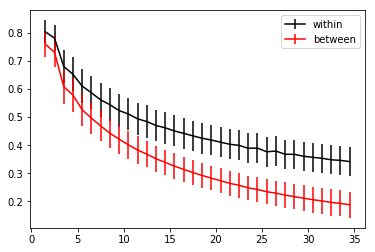

In [3]:
# Plotting the within/between curve
%matplotlib inline

plot_wb_curve(T, path='data', hems='L')

## Breaking down (DCBC steps)

**1. Choose an appropriate data set**

To what goal we want to achieve, the underlying dataset can be varying in terms of the type (for example, we can carry out to use functional resting-state connectivity pattern if we want to know how good the given parcellation in predicting functional resting-state boundaries, see paper for more details). We start here of choosing an appropriate dataset.

The public `evaluate` function of class `DCBC` will iteratively scan all subject data `sxx` in the `data` folder. Structure as below.
```
project/
 └───data/
        s02/
	 |   s02.L.wbeta.32k.func.gii
	 |   s02.R.wbeta.32k.func.gii
	...
	s31/
	 |   s31.L.wbeta.32k.func.gii
	 |   s31.R.wbeta.32k.func.gii

```

There are two connectivity profile in each of the subject folder `sxx` for left and right hemisphere, respectively. User can copy your own subject data into 'data' folder and make sure it follows the above structure. 

**2. Define and calculate distance metrics**

The class `DCBC` will pass in parameter `dist_file` as private variable which represents the distance metric between all vertex/voxel pairs. We provide some pre-computed distance metrics at <a href="http://www.diedrichsenlab.org/" target="_blank">this link</a>. Or you can use helper function `compute_distance` to compute your own distance. For instance, the below code segmentation calculates the euclidean distance for each vertex pairs of HCP standard mesh of left hemisphere.

In [1]:
from compute_distance import compute_dist

dist = compute_dist(files='parcellations/fs_LR_32k template/fs_LR.32k.L.sphere.surf.gii',type='euclidean',max_dist=50,dense=False)
print(dist.shape)

(32492, 32492)


there are also few options to controll the ouput distance file. If `dense=True`, the output distance file will be converted to sparse matrix. It would be beneficial for the very large distance matrix. `max_dist` controlls the maximum distance between the vertex pairs to calculation. `type` indicates which distance kernel will be applied.

**3. Get the parcellation**

We organized and provide several state-of-the-art or commonly used cortical parcellations in HCP standard fs-LR 32k template in `parcellations` folder. For the current version of DCBC project, we only support this template, the nifti file will be included soon in the updates. User can also copy own parcellation files to this folder.

In [6]:
# Load cortical parcellation from label.gii file
#  Extract the first data array as the parcels, make sure the input parcels has a shape of (N,)
gii_file = nb.load('parcellations/Power2011.32k.L.label.gii')
parcels = gii_file.darrays[0].data
print(parcels.shape)

(32492,)


**4. Define and compute similarity measures**

In each iteration of the subject evaluation, DCBC computes the similarity matrix between each vertex for further comparison. User can also use helper function `compute_similarity` to calculate other similarity matrix. For example below:

In [1]:
from compute_similarity import compute_similarity

similarity = compute_similarity(files='data/s02/s02.L.wbeta.32k.func.gii', type='pearson', dense=False, mean_centering=True)
print(similarity.shape)

[[ 1.         -0.04528929 -0.04379716 ...  0.12168833  0.16420421
   0.18852623]
 [-0.04528929  1.         -0.25283196 ... -0.5744775  -0.3631204
  -0.50815962]
 [-0.04379716 -0.25283196  1.         ...  0.15547672  0.2734931
   0.29205011]
 ...
 [ 0.12168833 -0.5744775   0.15547672 ...  1.          0.74378955
   0.94131895]
 [ 0.16420421 -0.3631204   0.2734931  ...  0.74378955  1.
   0.86633487]
 [ 0.18852623 -0.50815962  0.29205011 ...  0.94131895  0.86633487
   1.        ]]


(32492, 32492)


This example shows how to generate pearson's correlation for the functional connectiviy of subject 02's left hemisphere. Variable `type` controls the similarity kernel, e.g `cosine`, `pearson`. If `dense=True`, then the output will be dense matrix. If `mean_centering=True` then the subject's connectivity pattern will be mean centered before doing the calculation.

**5. Bin and integrate across bins**

The parameter `binWidth` is essential to get a good evaluation result as we described in the paper. Default bin width was set to 1 mm as it is a good compromise between bias, variances, and computational cost. But this can be changed based on your distance file or others. Here we show an example of passing 2.5 mm bin width as a comparison to the 1 mm result.

In [8]:
# Create a DCBC evaluation object of the desired evaluation parameters(left hemisphere)
myDCBC = DCBC(hems='L', maxDist=35, binWidth=2.5, dist_file="distanceMatrix/distSphere_sp.mat")

# Do the valuation on the parcellation 
T = myDCBC.evaluate(parcels)

evaluating L hemisphere of  s02 


s03 


s04 


s06 


s08 


s09 


s10 


s12 


s14 


s15 


s17 


s18 


s19 


s20 


s21 


s22 


s24 


s25 


s26 


s27 


s28 


s29 


s30 


s31 


**6. Plotting results**

The helper function file `plotting.py` contains the plotting function `plot_wb_curve` to decode the result from previous steps. The output figure will be within- and between parcel correlation curve. A larger difference between the two curve indicates the given parcellation has better performance in predicting the underlying type data boundaires. Below is the example within- and between- curve for the left hemisphere of `Power 2011` parcellation. 

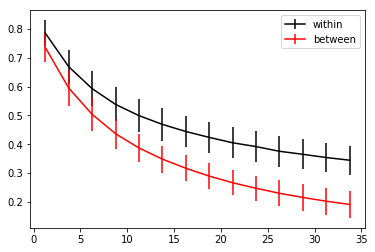

In [10]:
# Plotting the within/between curve
%matplotlib inline

plot_wb_curve(T, path='data', hems='L')

Finally, from the above result observation, we can compare the quality of different parcellations. If you want to get the real value of the curve at each bin, you can access to the returned dictionary structure.